# Lab 4: IT-based feature selection applied to hyperspectral image band selection 

### Question 1

On souhaite implémenter l'algorithme mRMR, dont la finalité est de sélectionner les bandes spectrales représentant le mieux la diversité et la complémentarité d'une image hyperspectrale.

Les bandes sont sélectionnées dans un tableau à deux dimensions, X, et comparées à un vecteur y, de même longueurs que chaque vecteur x qui compose X. La sélection des bandes se fait selon le critère suivant :
$$z_1 = \arg \max_{x \in X} \left [ I(x ; y) \right ]$$
$$\forall k \geq 2 \ \ \ z_k = \arg \max_{x \in X-\{z_1, z_2, ..., z_{k-1}\}}
\left [ I(x ; y) - \frac{1}{k-1} \sum_{i = 1}^{k-1} I(z_i ; x) \right ]$$
où $z_i$ est la ième bande sélectionnée.

Comme cette sélection se fait à l'aide de la quantité d'information, on a besoin des fonctions définies pour calculer cette quantité lors du TP 3 :

In [1]:
import numpy as np
from math import log

def matrice_contingence(x, y):
    M = np.array([[0 for _ in range(max(y)+1)] for _ in range(max(x)+1)])
    for i in range(len(x)):
        M[x[i]][y[i]] += 1
    return M

def distribution_conjointe(x, y):
    M = matrice_contingence(x, y)/len(x)
    for i in range(len(M)):
        for j in range(len(M[0])):
            M[i][j] += 10**(-15)
    return M

def p(DC, a, b):
    return DC[a][b]

def p_x(DC, a):
    return sum(p(DC, a, b) for b in range(len(DC[0])))
    
def p_y(DC, b):
    return sum(p(DC, a, b) for a in range(len(DC)))

def I(x, y):
    answer = 0
    DC = distribution_conjointe(x, y)
    for i in range(max(x)+1):
        for j in range(max(y)+1):
            answer += p(DC, i, j) * log(p(DC, i, j)/(p_x(DC, i)*p_y(DC, j)), 2.0)
    return answer

L'image hyperspectrale que nous allons étudier pour ce TP se nomme "Indian Pines" ; on charge cette image dans une variable éponyme :

In [2]:
from scipy.io import loadmat

mat = loadmat('Indian_pines.mat')
indian_pines = np.reshape(mat["indian_pines"], (145*145, 220))

Les valeurs du tableau indian_pines sont comprises entre 900 et 1000. C'est pourquoi, pour éviter de manipuler des matrices de trop grande taille, on transforme ces valeurs en entiers compris entre 0 et 15.

Pour cela, on divise l'intervalle entre la plus petite et la plus grande valeur d'indian_pines en 16 intervalles plus petits, et chaque valeur d'indian_pines est remplacée par le numéro de l'intervalle auquel elle appartient.

On ne modifie pas la variable indian_pines en elle-même ; on crée un nouveau tableau, X, qui a les mêmes dimensions qu'indian_pines, et dont chaque valeur est le numéro d'intervalle de la valeur d'indian_pines correspondante.

In [4]:
def hist_class(x, classes):
    n = len(classes)
    for i in range(n-1):
        if x >= classes[i] and x < classes[i+1] :
            return i
    if x == classes[n-1]:
        return n-2

hist = np.histogram(indian_pines, bins = 16)
X = np.array([[hist_class(indian_pines[i][j], hist[1]) for j in range(220)] for i in range(145*145)])

On crée ensuite le vecteur Y, qui est une autre image hyperspectrale. Ses valeurs sont comprises entre 0 et 16, d'où la division en 16 classes des valeurs d'indian_pines.

In [5]:
mat = loadmat('Indian_pines_gt.mat')
Y = np.reshape(mat["indian_pines_gt"], (145*145))

On a ainsi créé trois tableaux partageant le même nombre de lignes.

Enfin, dans ces trois tableaux, on supprime chaque ligne i telle que Y\[i\]=0 :

In [6]:
indian_pines = indian_pines[~(Y[:]==0)]
X = X[~(Y[:]==0)]
Y = Y[~(Y[:]==0)]

On définit maintenant la fonction destinée à sélectionner les bandes les plus pertinentes de notre image hyperspectrale.

Cette fonction prend en paramètre k, le nombre de bandes à sélectionner, ainsi que le tableau X et le vecteur Y. Les bandes sont sélectionnées selon le critère établi au début du TP, en distinguant les cas où k=1 et où k >= 2. La fonction retourne la liste des indices des bandes de X sélectionnées :

In [7]:
def Z(k, X, Y): #k doit être supérieur ou égal à 1
    band_list = []
    z_list = []
    arg, value = 0, 0
    for i in range(220):
        x = np.array([X[j][i] for j in range(len(Y))])
        i_Yx = I(Y, x)
        if i_Yx > value :
            arg, value = i, i_Yx
    band_list.append(arg)
    z = np.array([X[j][arg] for j in range(len(Y))])
    z_list.append(z)
    for l in range(2, k+1):
        arg, value = 0, 0
        for i in range(220):
            if i not in band_list :
                x = np.array([X[j][i] for j in range(len(Y))])
                c_Yx = I(Y, x) - sum(I(z, x) for z in z_list)/(k-1)
                if c_Yx > value :
                    arg, value = i, c_Yx
        band_list.append(arg)
        z = np.array([X[j][arg] for j in range(len(Y))])
        z_list.append(z)
    return band_list

Par exemple, la liste des 20 bandes les plus pertinentes de notre image hyperspectrale est :

In [8]:
band_list = Z(20, X, Y)
print(band_list)

[27, 12, 11, 26, 17, 120, 121, 119, 122, 52, 116, 143, 118, 74, 123, 73, 142, 129, 72, 130]


Comme le premier numéro de la liste est 27, la première bande correspond à la colonne d'indice 27 dans X. De même, la seconde bande correspond à la colonne d'indice 12 dans X, la troisième bande à la colonne d'indice 11, etc.

### Question 2

On souhaite maintenant implémenter un classifieur k-NN, que l'on entraînerait uniquement sur les bandes d'indian_pines sélectionnées à la question 2, et que l'on testerait sur l'ensemble des vecteurs d'indian_pines.

On définit donc une fonction prenant une liste de bandes sélectionnées en paramètre et retourne le taux de bonne classification d'un classifieur entraîné de la manière décrite ci-dessus.

Avant toute chose, cependant, on prépare les données pour l'entraînement du classifieur : il s'agit, d'une part, du tableau indian_pines modifié de manière à ce que les colonnes ne correspondant pas à aucune bande sélectionnée soient remplies de "0" (les autres colonnes contenant bien leurs éléments respectifs), et d'autre part du vecteur Y. Les données de test correspondent quant à elles à indian_pines avant la modification précédente et à Y. En effet, il faut que les données d'entraînement et les données de test aient les mêmes dimensions.

In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

def kNNclassifier_overall_accuracy(band_list):
    X_train = np.array([[0 for _ in range(220)] for _ in range(len(Y))])
    for i in range(len(Y)):
        for j in range(220):
            if j in band_list:
                X_train[i][j] = indian_pines[i][j]
    y_train = Y
    X_test = indian_pines
    y_test = Y
    
    kNNclassifier = KNeighborsClassifier(n_neighbors = 5, weights='uniform', algorithm='auto')
    kNNclassifier.fit(X_train, y_train) 
    y_pred = kNNclassifier.predict(X_test)
    return accuracy_score(y_test,y_pred)*100

Prenons connaissance du taux de bonne classification d'un classifieur k-NN qui aurait été entraîné uniquement à l'aide des bandes sélectionnées à la question précédente :

In [9]:
print(kNNclassifier_overall_accuracy(band_list))

85.70592252902722


On constate que ce taux est plutôt élevé : cela prouve qu'il suffit d'utiliser un nombre restreint de bandes sélectionnées d'une image hyperspectrale pour obtenir un bon classifieur k-NN.

### Question 3

Traçons la courbe du taux de bonne classification d'un classifieur k-NN entraîné uniquement sur une liste de bandes sélectionnées d'une image hyperspectrale et testé sur l'ensemble de cette image, en fonction du nombre de bandes sélectionnées :

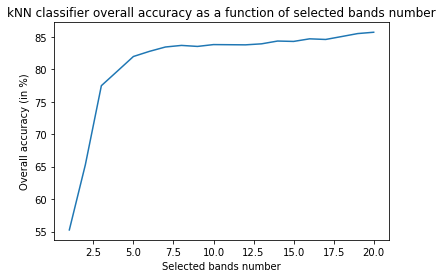

In [10]:
import matplotlib.pyplot as plt

x_list = []
y_list = []
for k in range(1, 21):
    x_list.append(k)
    band_list = Z(k, X, Y)
    y_list.append(kNNclassifier_overall_accuracy(band_list))
plt.title("kNN classifier overall accuracy as a function of selected bands number")
plt.plot(x_list, y_list)
plt.xlabel("Selected bands number")
plt.ylabel("Overall accuracy (in %)")
plt.show()

On observe l'augmentation de cette courbe : en effet, plus il y a de bandes sélectionnées, meilleure est la représentation de l'image hyperspectrale, et meilleure est la classification.

On remarque que, entre une et sept bandes sélectionnées, le taux de bonne classification augmente drastiquement, avant d'entamer une croissance bien plus lente. On interprète ceci comme le fait qu'à partir d'un certain nombre de bandes sélectionnées, en augmenter encore le nombre augmente relativement peu les capacités du classifieur.